In [1]:
#Импорт всего

# Currently %tensorflow_version 2.x installs beta1, which doesn't work here.
# %tensorflow_version can likely be used after 2.0rc0  
#!pip install tf-nightly-gpu-2.0-preview
#!pip install tf-nightly-gpu-2.0-preview
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow

import tensorflow as tf

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
%matplotlib inline
import cv2 as cv

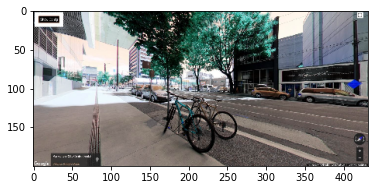

In [2]:
#Читаем картинку
im = cv.imread('pics/irCUU.png')
    
# размеры изображения
newH = 200  #высота
newW = int(im.shape[1]*200/im.shape[0]) # ширина 
#сжатая картинка
im = cv.resize(im, (newW, newH)) 
#Выводим 

plt.imshow(im)
plt.show()

In [3]:
#Настройка модели
cv.setUseOptimized(True) #режим оптимизации
cv.setNumThreads(6)      #количество потоков

In [4]:
# Объект Selective Search Segmentation
sss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

# запускаем с картинкой
sss.setBaseImage(im)
  
# Выбираем точный метод 
sss.switchToSelectiveSearchQuality()

# Делаем selective search segmentation 
rects = sss.process() 
#вернёт массив прямоугольников, гдевозможно что-то есть
print(rects.shape) #число найденых объектов

(4735, 4)


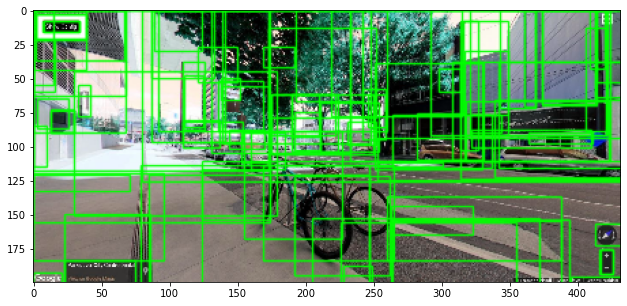

In [5]:
#Построим области

num_Rects = 100 #число выводимых region proposals (прямоугольников)

#создаем копию исходной картинки
im_ = im.copy()

for i, rect in enumerate(rects): 
    if (i < num_Rects): #пока не больше 
        # x,y - координаты левого верхнего угла; w, h - ширина и высота области
        x, y, w, h = rect
        # рисуем рамку      
        cv.rectangle(im_, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA) 
    else: 
        break 

# Рисуем на экран
plt.figure(figsize=(16,5))
plt.imshow(im_) 
plt.show()

In [6]:
# выводит картинку
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

#  Грузим и обрабатываем картинку
def download_and_resize_image(url, new_width=256, new_height=256, display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    #read image
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    #print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    
    return filename

#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
   #Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

def draw_boxes(image, boxes, class_names, scores, max_boxes=5, min_score=0.1):
    #Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              30)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    qty = 0
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            qty+=1
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
              image_pil,
              ymin,
              xmin,
              ymax,
              xmax,
              color,
              font,
              display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    print(f'objects detected: {qty}')
    
    return image

In [7]:
# формируем тензор
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [8]:
def run_detector(detector, path, max_boxes = 5, min_score = 0.1):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()
    #print(result['detection_scores'])
    result = {key:value.numpy() for key,value in result.items()} 

    image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes, min_score)

    display_image(image_with_boxes)
    
    return result

In [9]:
#  Найдем рамку
# max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции
# можно менять
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=5, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    if len(image.shape)>3:
        image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
    I_shape=np.uint8(image).shape
    #print(I_shape)
    im_array=[]
    for i in range(min(boxes.shape[0], max_boxes)): 
        #print(tuple(boxes[i]))
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])


            yminI = np.int(ymin*I_shape[0])
            ymaxI = np.int(ymax*I_shape[0])
            xminI = np.int(xmin*I_shape[1])
            xmaxI = np.int(xmax*I_shape[1])
            imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
            #print(imf.shape,imf[0,0,:])

            im_array.append(imf.copy())  
    return im_array

In [10]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes=5, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""

    image_pil = np.array(image)
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])

            imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes, min_score)

    return imf

In [11]:
#Чтение имен кадров
import os, fnmatch
root_path = './pics/'
listOfFiles = os.listdir(root_path)
pattern = '*.png'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))
List_name[0]

array('./pics/irCUU.png', dtype='<U16')

### faster_rcnn

In [12]:
#загрузка детектора
# module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Font not found, using default font.
objects detected: 6
Wall time: 56.6 s


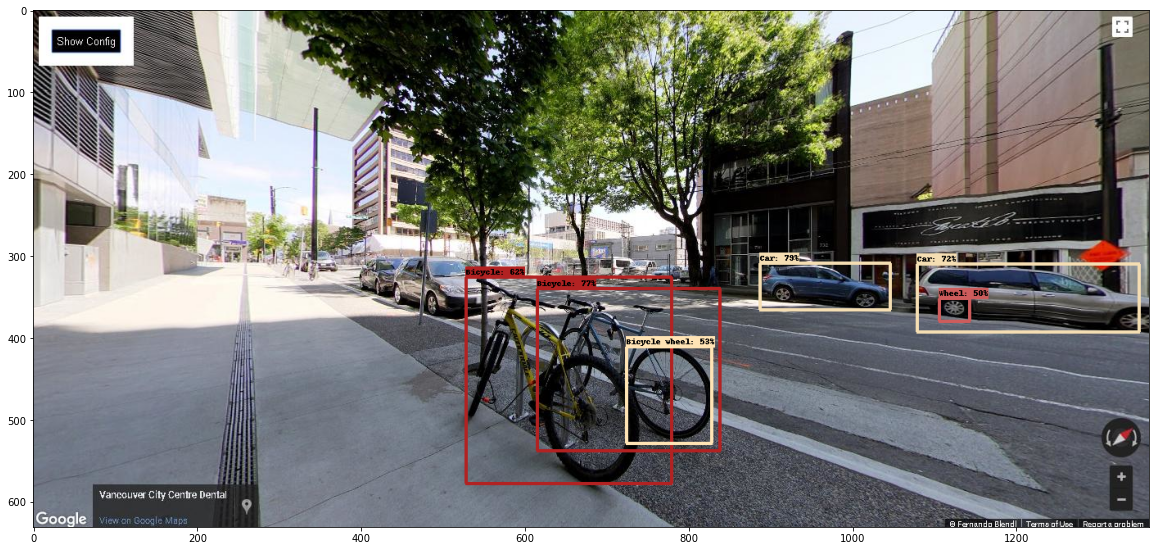

In [13]:
%%time
result = run_detector(detector, List_name[0], 10, 0.5)

Только в 6 объектах из предполагаемых 10 детектор уверен более чем на 50%

Font not found, using default font.
objects detected: 7
Wall time: 33.7 s


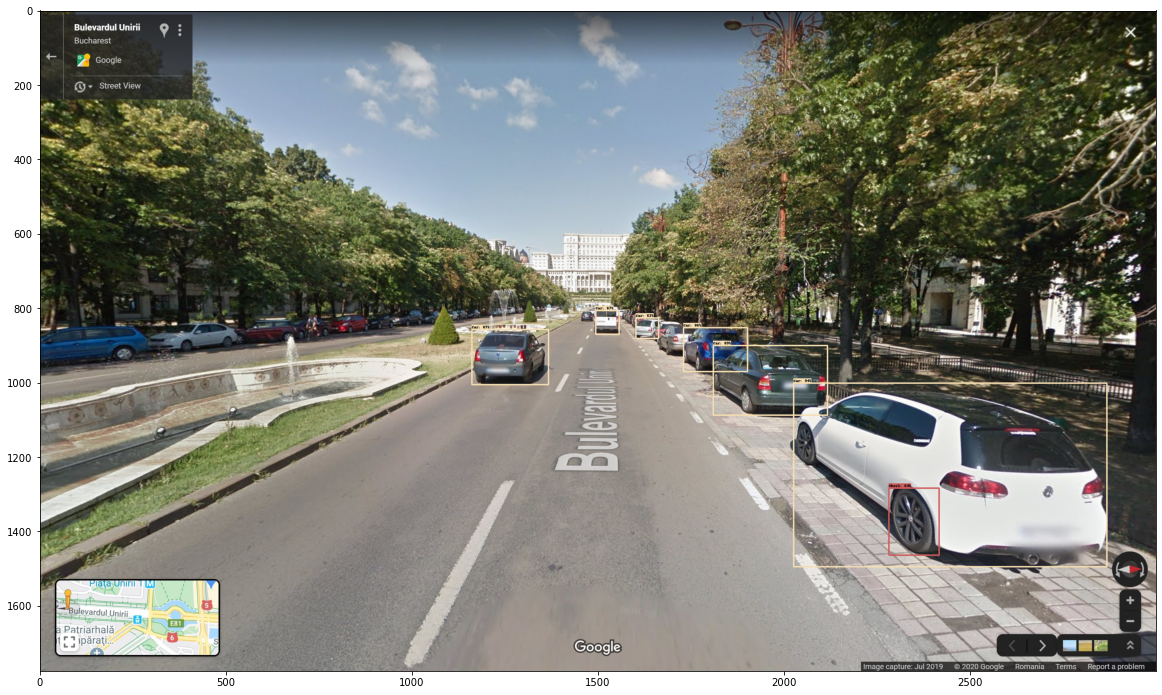

In [14]:
%%time
result = run_detector(detector, List_name[1], 10, 0.5)

А на этой картинке он уверен в 7 из 10

### SSD

In [15]:
#загрузка детектора
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Font not found, using default font.
objects detected: 2
Wall time: 5.4 s


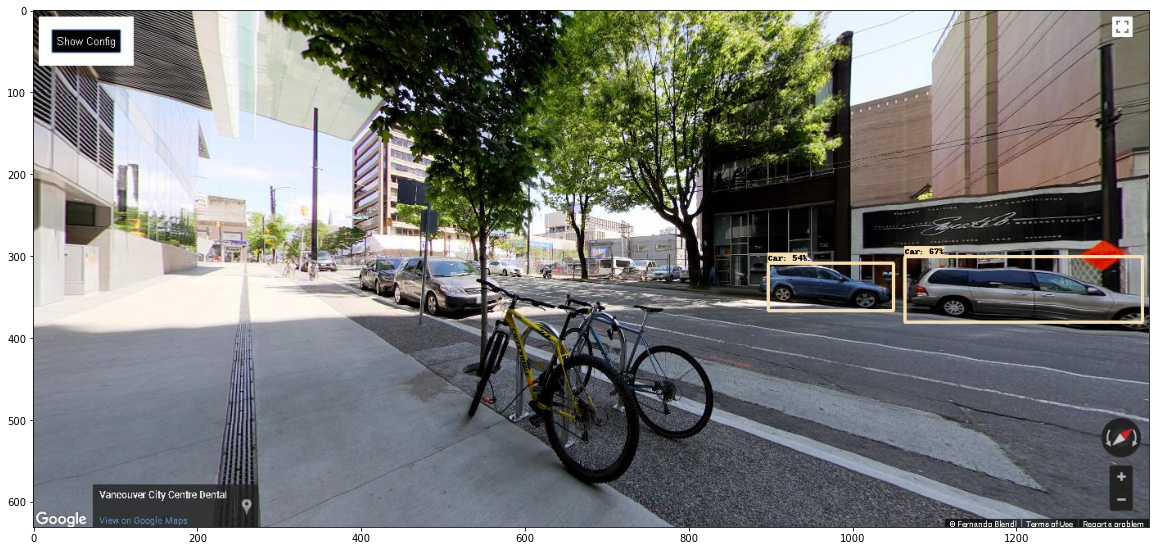

In [16]:
%%time
result = run_detector(detector, List_name[0], 10, 0.5)

Данный детектор работает гораздо быстрее, но находит сильно меньше объектов с той же степенью уверенности: всего 2 из 10

Font not found, using default font.
objects detected: 1
Wall time: 432 ms


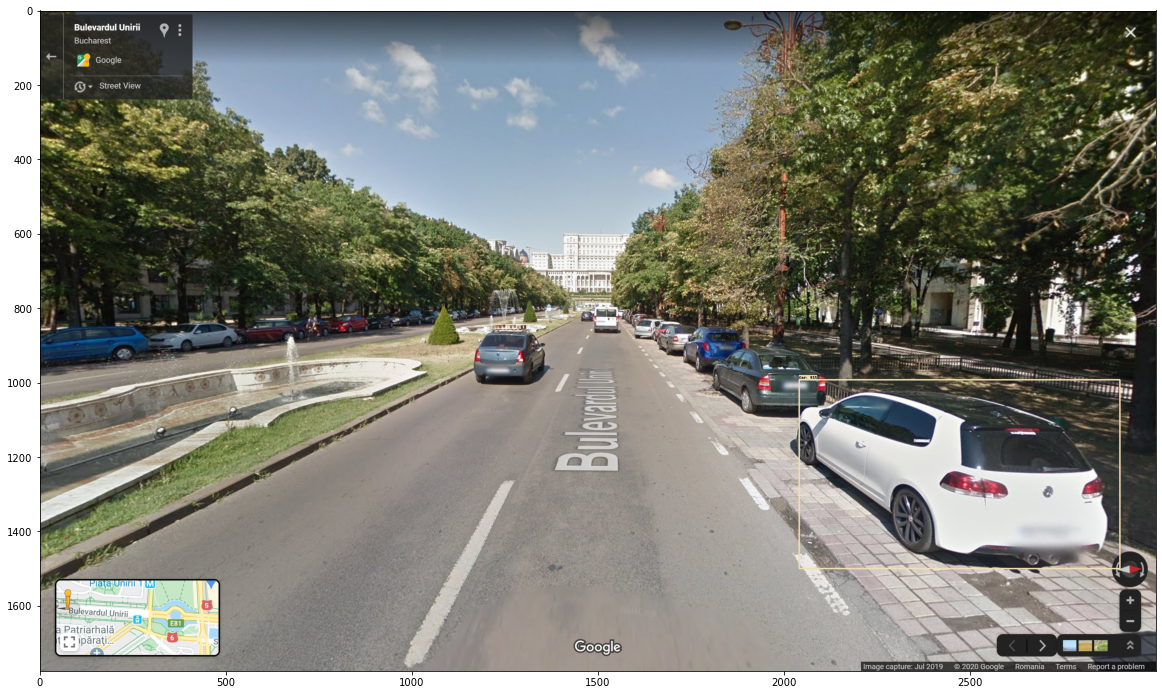

In [17]:
%%time
result = run_detector(detector, List_name[1], 10, 0.5)

А на второй картинке только 1 из 10 он смог отметить с вероятностью принадлежности более, чем 50%

SSD оказался гораздо быстрее Faster R-CNN, но сильно проигрывает ему в точности

#### SpineNet short review

Одна из новых моделей, разработана в Google Research. Преимущество - высокая скорость работы, меньшее количество затрачиваемых вычислительных ресурсов (на 60% меньше вычислений и обходит конкурирующие архитектуры в точности) и прирост в точности
Может применяться как для классификации, так и для распознавания объектов <br><br>
_Проблема классификации была весьма эффективно решена при помощи архитектур типа “энкодер-декодер”, в которых энкодерам свойственно постепенное уменьшение масштаба. Однако эта архитектура не способна эффективно генерировать сильные мульти-масштабные признаки, необходимые для задач обнаружения объектов, а именно их единовременного распознавания и локализации. (c)_ <br><br>
Нововведение: эффективная генерация признаков разных масштабов за счет сверточных слоев смешанных размеров

* https://arxiv.org/pdf/1912.05027.pdf
* https://medium.com/nuances-of-programming/spinenet-%D0%BD%D0%B5%D1%82%D1%80%D0%B0%D0%B4%D0%B8%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F-%D0%B0%D1%80%D1%85%D0%B8%D1%82%D0%B5%D0%BA%D1%82%D1%83%D1%80%D0%B0-backbone-%D1%81%D0%B5%D1%82%D0%B8-%D0%BE%D1%82-google-brain-6758854287bd
* https://neurohive.io/ru/papers/spinenet-arhitektura-dlya-raspoznavaniya-i-lokalizacii-obekta-na-izobrazhenii/    